In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
from utils import LaplaceFilter, LowBandFilter

In [2]:
df  = pd.read_csv('DataBase.csv')
key = 'ax'
df.head()

,device,kernel
0,"{'time': 416.47, 's2': {'ax': -0.06943185, 'ay...","{'pitch': 0.0, 'roll': 0.0, 'yaw': 0.0, 'wx': ..."
1,"{'time': 416.47, 's2': {'ax': -0.06943185, 'ay...","{'pitch': 0.0, 'roll': 0.0, 'yaw': 0.0, 'wx': ..."
2,"{'time': 416.49, 's2': {'ax': -0.05985504, 'ay...","{'pitch': 0.0, 'roll': 0.0, 'yaw': 0.0, 'wx': ..."
3,"{'time': 416.51, 's2': {'ax': -0.1077391, 'ay'...","{'pitch': 0.0, 'roll': 0.0, 'yaw': 0.0, 'wx': ..."
4,"{'time': 416.51, 's2': {'ax': -0.1077391, 'ay'...","{'pitch': 0.0, 'roll': 0.0, 'yaw': 0.0, 'wx': ..."


# TRATAMENTO DE DADOS

In [3]:
device = df.device.apply(ast.literal_eval).apply(pd.Series)
device

,time,s2,s1
0,416.470,"{'ax': -0.06943185, 'ay': -2.954445, 'wz': -0....","{'ax': -0.01197101, 'ay': -2.920926, 'wz': -0...."
1,416.470,"{'ax': -0.06943185, 'ay': -2.954445, 'wz': -0....","{'ax': -0.01197101, 'ay': -2.920926, 'wz': -0...."
2,416.490,"{'ax': -0.05985504, 'ay': -2.762909, 'wz': -0....","{'ax': -0.03591302, 'ay': -2.913743, 'wz': -0...."
3,416.510,"{'ax': -0.1077391, 'ay': -2.961627, 'wz': -0.0...","{'ax': -0.02154782, 'ay': -2.942474, 'wz': -0...."
4,416.510,"{'ax': -0.1077391, 'ay': -2.961627, 'wz': -0.0...","{'ax': -0.02154782, 'ay': -2.942474, 'wz': -0...."
...,...,...,...
566862,7286.423,"{'ax': 9.344569, 'ay': -3.37343, 'wz': -0.0050...","{'ax': 9.344569, 'ay': -3.529053, 'wz': -0.005..."
566863,7286.443,"{'ax': 9.459491, 'ay': -3.37343, 'wz': -0.0173...","{'ax': 9.334992, 'ay': -3.435679, 'wz': -0.017..."
566864,7286.443,"{'ax': 9.459491, 'ay': -3.37343, 'wz': -0.0173...","{'ax': 9.334992, 'ay': -3.435679, 'wz': -0.017..."
566865,7286.443,"{'ax': 9.459491, 'ay': -3.37343, 'wz': -0.0173...","{'ax': 9.334992, 'ay': -3.435679, 'wz': -0.017..."


In [4]:
kernel = df.kernel.apply(ast.literal_eval).apply(pd.Series)
kernel

,pitch,roll,yaw,wx,wy,wz,ax,ay,az
0,0.00,0.0,0.00,5.0,2.0,-1.0,-91.0,123.0,474.0
1,0.00,0.0,0.00,5.0,2.0,-1.0,-91.0,123.0,474.0
2,0.00,0.0,0.00,5.0,2.0,-1.0,-91.0,123.0,474.0
3,0.00,0.0,0.00,5.0,2.0,-1.0,-91.0,123.0,474.0
4,0.00,0.0,0.00,5.0,2.0,-1.0,-91.0,123.0,474.0
...,...,...,...,...,...,...,...,...,...
566862,21.96,-54.9,24.50,3.0,4.0,-6.0,380.0,189.0,265.0
566863,21.96,-54.9,24.50,3.0,4.0,-6.0,380.0,189.0,265.0
566864,21.96,-54.9,24.50,3.0,-4.0,0.0,381.0,184.0,260.0
566865,21.96,-54.9,24.50,3.0,-4.0,0.0,381.0,184.0,260.0


In [5]:
df = pd.DataFrame({
    'time': device.time,
    'target':   kernel[key],
    f'Ys1': [data[key] for data in device.s1],
    f'Ys2': [data[key] for data in device.s2],
})

df.head()

,time,target,Ys1,Ys2
0,416.47,-91.0,-0.011971,-0.069432
1,416.47,-91.0,-0.011971,-0.069432
2,416.49,-91.0,-0.035913,-0.059855
3,416.51,-91.0,-0.021548,-0.107739
4,416.51,-91.0,-0.021548,-0.107739


In [6]:
print(float(np.round(df.time.diff().median(), 3)))
dt = 0.020

0.02


In [7]:
def normalizeTable(df, key, dt=0.15):
    df[key] = df[key] - df[key].iloc[0]  # inicia em zero
    # remove duplicados, mantendo o primeiro (ou use .mean() se quiser agregar)
    df = df.drop_duplicates(subset=[key], keep='first')

    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)

    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


df = normalizeTable(df, 'time', dt)
df.head()

,time,target,Ys1,Ys2
0,0.00,-91.0,-0.011971,-0.069432
1,0.02,-91.0,-0.035913,-0.059855
2,0.04,-91.0,-0.021548,-0.107739
3,0.06,-91.0,-0.002394,-0.007183
4,0.08,-91.0,-0.081403,-0.090980


In [8]:
bkp = df.copy()

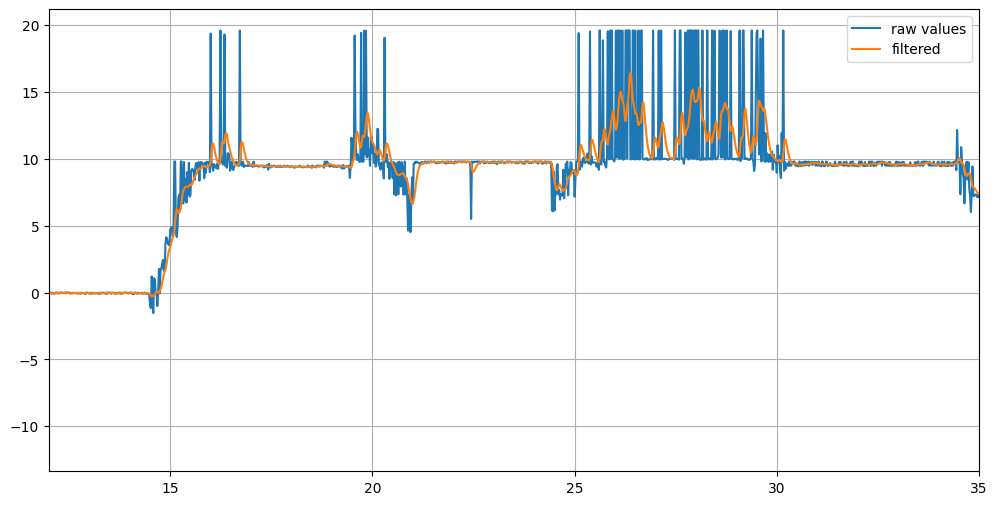

In [9]:
df = bkp.copy()
filter = LaplaceFilter(Ts=0.2, UP=1e-3, dt=dt)
yRaw   = df.Ys1.values
SAMPLE = (12, 35)

df['Ys1'] = filter.apply(df.Ys1.values)
df['Ys2'] = filter.apply(df.Ys2.values)
target = df.loc[(df.time > 12) & (df.time < 25)]

plt.figure(figsize=(12, 6))
plt.plot(df.time, yRaw, label='raw values')
plt.plot(df.time, df.Ys1, label='filtered')
plt.legend(), plt.grid(), plt.xlim(SAMPLE)
plt.show()

In [10]:
bkp = df.copy()

# FORMATANDO DADOS

In [11]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}[n-0]'] = table[key]

    for i in range(1, n):
        table[f'{var}[n-{i}]'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}[n-0]'] + [f'{var}[n-{i}]' for i in range(1, n)]
    return table[columns]


size = 10

In [12]:
xS1 = getStates(df, 'Ys1', 'Ys1', size)
xS1.head()

,Ys1[n-0],Ys1[n-1],Ys1[n-2],Ys1[n-3],Ys1[n-4],Ys1[n-5],Ys1[n-6],Ys1[n-7],Ys1[n-8],Ys1[n-9]
0,-0.000399,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,-0.002519,-0.000399,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,-0.006644,-0.002519,-0.000399,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,-0.010318,-0.006644,-0.002519,-0.000399,0.000000,0.0,0.0,0.0,0.0,0.0
4,-0.014178,-0.010318,-0.006644,-0.002519,-0.000399,0.0,0.0,0.0,0.0,0.0


In [13]:
xS2 = getStates(df, 'Ys2', 'Ys2', size)
xS2.head()

,Ys2[n-0],Ys2[n-1],Ys2[n-2],Ys2[n-3],Ys2[n-4],Ys2[n-5],Ys2[n-6],Ys2[n-7],Ys2[n-8],Ys2[n-9]
0,9.040207,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,8.003515,9.040207,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,6.462494,8.003515,9.040207,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,4.901664,6.462494,8.003515,9.040207,0.000000,0.0,0.0,0.0,0.0,0.0
4,3.542383,4.901664,6.462494,8.003515,9.040207,0.0,0.0,0.0,0.0,0.0


In [14]:
df = pd.concat([df.time, xS1, xS2, df.target], axis=1)
df

,time,Ys1[n-0],Ys1[n-1],Ys1[n-2],Ys1[n-3],Ys1[n-4],Ys1[n-5],Ys1[n-6],Ys1[n-7],Ys1[n-8],...,Ys2[n-1],Ys2[n-2],Ys2[n-3],Ys2[n-4],Ys2[n-5],Ys2[n-6],Ys2[n-7],Ys2[n-8],Ys2[n-9],target
0,0.00,-0.000399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-91.0
1,0.02,-0.002519,-0.000399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.040207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-91.0
2,0.04,-0.006644,-0.002519,-0.000399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.003515,9.040207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-91.0
3,0.06,-0.010318,-0.006644,-0.002519,-0.000399,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.462494,8.003515,9.040207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-91.0
4,0.08,-0.014178,-0.010318,-0.006644,-0.002519,-0.000399,0.000000,0.000000,0.000000,0.000000,...,4.901664,6.462494,8.003515,9.040207,0.000000,0.000000,0.000000,0.000000,0.000000,-91.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343496,6869.92,9.392374,9.406192,9.415141,9.421245,9.426307,9.425747,9.426170,9.432047,9.429995,...,9.295340,9.273428,9.249589,9.238527,9.250214,9.299258,9.361169,9.382932,9.374484,378.0
343497,6869.94,9.377580,9.392374,9.406192,9.415141,9.421245,9.426307,9.425747,9.426170,9.432047,...,9.309158,9.295340,9.273428,9.249589,9.238527,9.250214,9.299258,9.361169,9.382932,379.0
343498,6869.96,9.364323,9.377580,9.392374,9.406192,9.415141,9.421245,9.426307,9.425747,9.426170,...,9.316793,9.309158,9.295340,9.273428,9.249589,9.238527,9.250214,9.299258,9.361169,380.0
343499,6869.98,9.354478,9.364323,9.377580,9.392374,9.406192,9.415141,9.421245,9.426307,9.425747,...,9.321519,9.316793,9.309158,9.295340,9.273428,9.249589,9.238527,9.250214,9.299258,380.0


In [15]:
len(df)

343501

# MODELO PREDITIVO

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

In [17]:
TEST_SIZE = 0.15

xData = df.drop(columns=['time', 'target'])
yData = df.target.values
display(xData.head())

,Ys1[n-0],Ys1[n-1],Ys1[n-2],Ys1[n-3],Ys1[n-4],Ys1[n-5],Ys1[n-6],Ys1[n-7],Ys1[n-8],Ys1[n-9],Ys2[n-0],Ys2[n-1],Ys2[n-2],Ys2[n-3],Ys2[n-4],Ys2[n-5],Ys2[n-6],Ys2[n-7],Ys2[n-8],Ys2[n-9]
0,-0.000399,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,9.040207,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,-0.002519,-0.000399,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,8.003515,9.040207,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,-0.006644,-0.002519,-0.000399,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,6.462494,8.003515,9.040207,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,-0.010318,-0.006644,-0.002519,-0.000399,0.000000,0.0,0.0,0.0,0.0,0.0,4.901664,6.462494,8.003515,9.040207,0.000000,0.0,0.0,0.0,0.0,0.0
4,-0.014178,-0.010318,-0.006644,-0.002519,-0.000399,0.0,0.0,0.0,0.0,0.0,3.542383,4.901664,6.462494,8.003515,9.040207,0.0,0.0,0.0,0.0,0.0


### REGRESSÃO LINEAR

score: 0.286


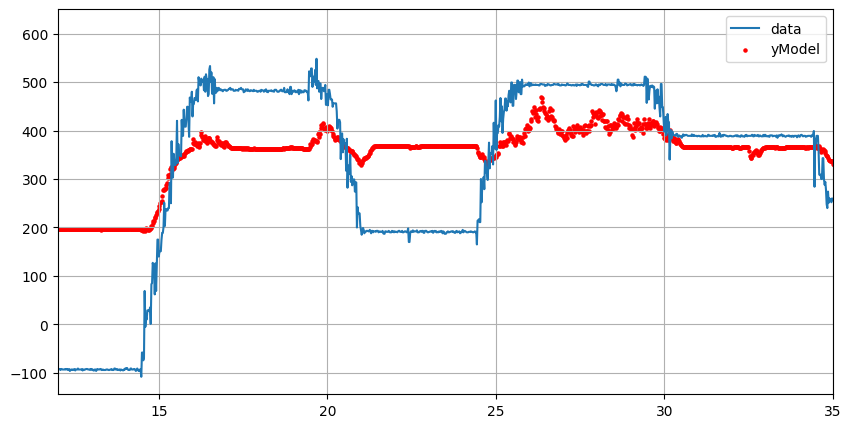

In [18]:
def linearRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=TEST_SIZE, random_state=42)
    model = LinearRegression()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = linearRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='red', label='yModel', s=5)
plt.legend(), plt.grid(), plt.xlim(SAMPLE)
plt.show()

### REGRESSÃO POLINOMIAL

score: 0.369


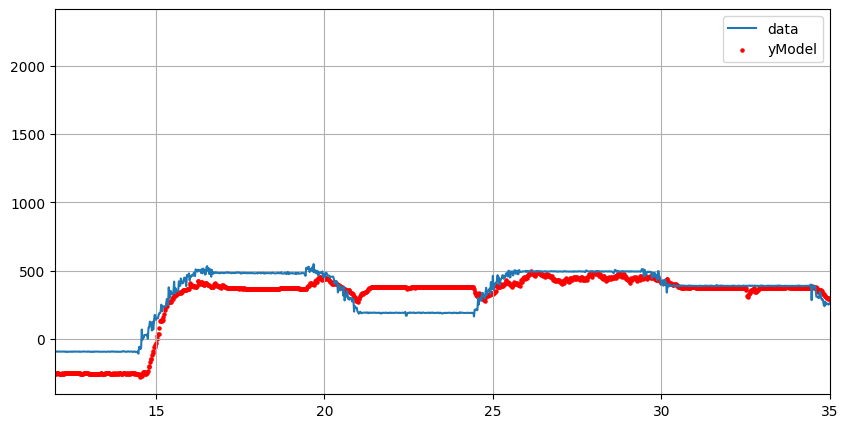

In [19]:
def polinomialRegression(xData, yData, degree=2):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=TEST_SIZE, random_state=42)
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = polinomialRegression(xData, yData, degree=2)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='red', label='yModel', s=5)
plt.legend(), plt.grid(), plt.xlim(SAMPLE)
plt.show()

### ÁRVORE DE DECISÃO

score: 0.548


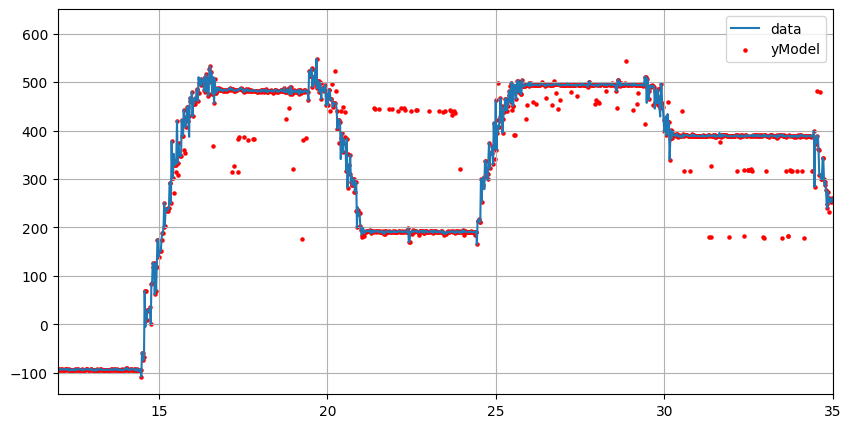

In [20]:
def decisionTreeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=TEST_SIZE, random_state=42)
    model = DecisionTreeRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = decisionTreeRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='red', label='yModel', s=5)
plt.legend(), plt.grid(), plt.xlim(SAMPLE)
plt.show()

### RANDOM FOREST

In [ ]:
def randomForestRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=TEST_SIZE, random_state=42)
    model = RandomForestRegressor()
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = randomForestRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='red', label='yModel', s=5)
plt.legend(), plt.grid(), plt.xlim(SAMPLE)
plt.show()

### SUPORTE VETORIAL PARA REGRESSÃO (SVR)

score: 0.610


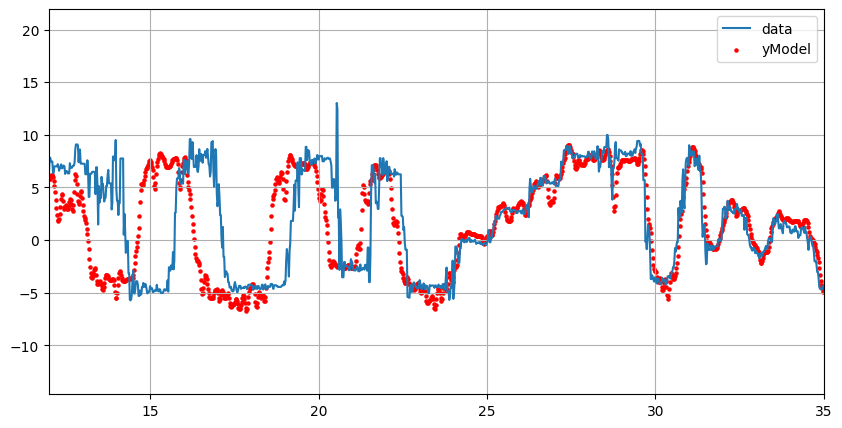

In [ ]:
def supportVectorRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=TEST_SIZE, random_state=42)
    model = SVR(kernel='rbf')  # kernel pode ser 'linear', 'poly', ou 'rbf'
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = supportVectorRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='red', label='yModel', s=5)
plt.legend(), plt.grid(), plt.xlim(SAMPLE)
plt.show()

### RIDGE REGRESSOR

score: 0.631


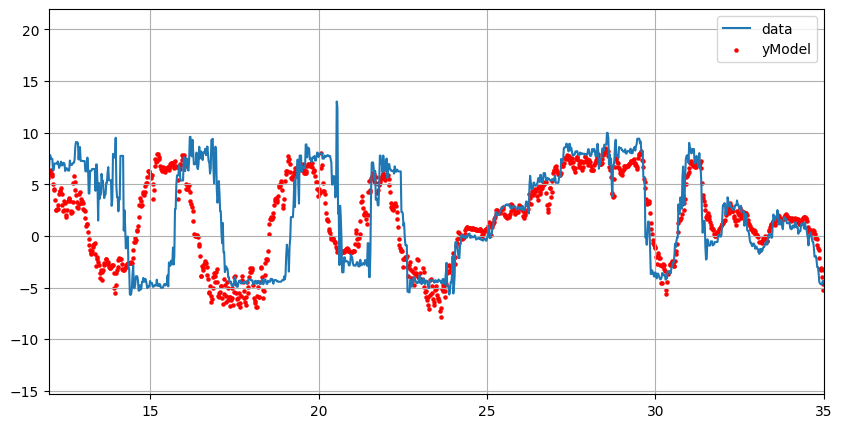

In [ ]:
def ridgeRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=TEST_SIZE, random_state=42)
    model = Ridge(alpha=1.0)  # Ajuste o parâmetro alpha para regularização
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = ridgeRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='red', label='yModel', s=5)
plt.legend(), plt.grid(), plt.xlim(SAMPLE)
plt.show()

### GRADIENT BOOSTER

score: 0.684


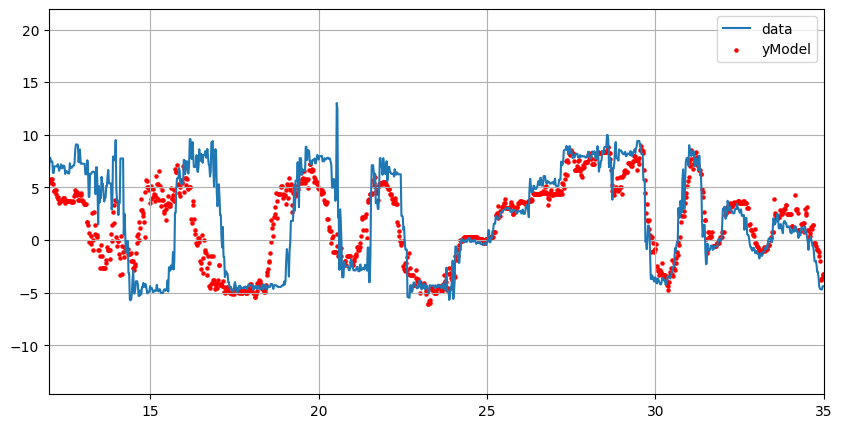

In [ ]:
def gradientBoostingRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=TEST_SIZE, random_state=42)
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = gradientBoostingRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='red', label='yModel', s=5)
plt.legend(), plt.grid(), plt.xlim(SAMPLE)
plt.show()

### K-NEAREST NEIGHBORS

score: 0.731


c:\Users\march\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\march\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\march\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\march\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\march\AppData\Local\Programs\Python\Python310\lib\subp

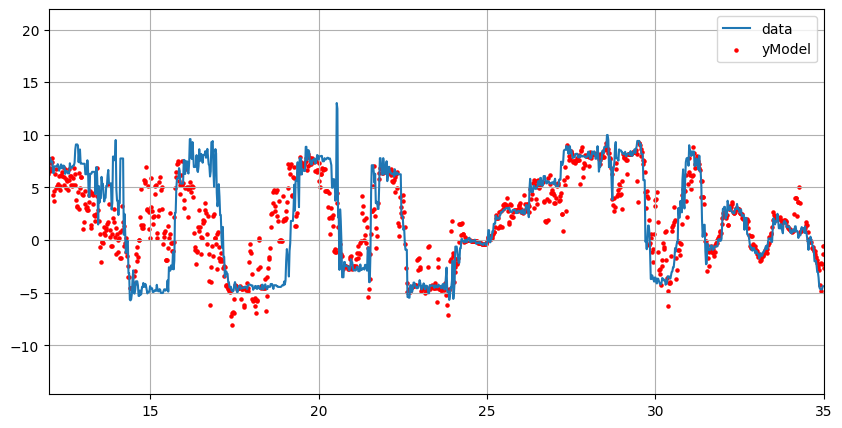

In [ ]:
def knnRegression(xData, yData):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=TEST_SIZE, random_state=42)
    model = KNeighborsRegressor(n_neighbors=5)  # Ajuste n_neighbors conforme necessário
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score = metrics.r2_score(yTeste, yModel)
    return model, score


model, score = knnRegression(xData, yData)
print(f'score: {score:.3f}')

yModel = model.predict(xData)
plt.figure(figsize=(10, 5))
plt.plot(df.time, yData, label='data')
plt.scatter(df.time, yModel, color='red', label='yModel', s=5)
plt.legend(), plt.grid(), plt.xlim(SAMPLE)
plt.show()

# TESTANDO COM NOVOS DADOS

In [ ]:
class StatesUpdater:
    states  = None
    initial = 0
    size    = 0

    def __init__(self, size, initial=0):
        self.initial = initial
        self.size    = size
        self.states  = initial * np.ones(size)
        
    def update(self, value):
        for i in range(self.size-1, 0, -1):
            self.states[i] = self.states[i-1]

        self.states[0] = value
        return self.states
    

states = StatesUpdater(3)
for i in range(1, 5): print(states.update(i))

[1. 0. 0.]
[2. 1. 0.]
[3. 2. 1.]
[4. 3. 2.]


In [ ]:
df = pd.read_csv('DataBase.csv')
df.head()

,device,kernel
0,"{'time': 1722.338, 's2': {'ax': 6.121974, 'ay'...","{'wx': -0.16705017509735767, 'wy': 0.044012142..."
1,"{'time': 1722.358, 's2': {'ax': 5.973533, 'ay'...","{'wx': -0.16705017509735767, 'wy': 0.044012142..."
2,"{'time': 1722.378, 's2': {'ax': 6.050148, 'ay'...","{'wx': -0.16705017509735767, 'wy': 0.044012142..."
3,"{'time': 1722.398, 's2': {'ax': 7.161057, 'ay'...","{'wx': -0.16705017509735767, 'wy': 0.044012142..."
4,"{'time': 1722.418, 's2': {'ax': 7.345411, 'ay'...","{'wx': -0.16705017509735767, 'wy': 0.044012142..."


In [ ]:
columns = xData.columns
columns

Index(['Ys1[n-0]', 'Ys1[n-1]', 'Ys1[n-2]', 'Ys1[n-3]', 'Ys1[n-4]', 'Ys1[n-5]',
       'Ys1[n-6]', 'Ys1[n-7]', 'Ys1[n-8]', 'Ys1[n-9]', 'Ys2[n-0]', 'Ys2[n-1]',
       'Ys2[n-2]', 'Ys2[n-3]', 'Ys2[n-4]', 'Ys2[n-5]', 'Ys2[n-6]', 'Ys2[n-7]',
       'Ys2[n-8]', 'Ys2[n-9]'],
      dtype='object')

In [ ]:
Yn1_states = StatesUpdater(size)
Yn2_states = StatesUpdater(size)
yData   = []

for i, row in bkp.iterrows():
    Ys1, Ys2 = row['Ys1'], row['Ys2']
    xData  = list(Yn1_states.update(Ys1)) + list(Yn2_states.update(Ys2))
    xData  = pd.DataFrame([xData], columns=columns)
    yData.append(model.predict(xData)[0])

yData[:5]

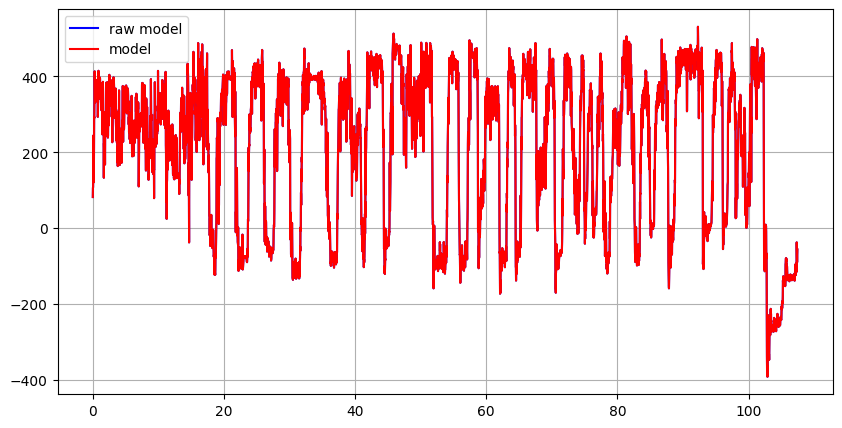

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(bkp.time, yData, label='raw model', color='blue')
plt.plot(bkp.time, yModel, label='model', color='red')
plt.legend(), plt.grid()
plt.show()

In [ ]:
metrics.r2_score(yData, yModel)

1.0